In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/My Drive/DS5500')

Mounted at /content/drive


In [2]:
!pip install h5py

In [3]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

import os
import sys
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import librosa
import librosa.display
import json
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, roc_auc_score, roc_curve, auc

In [4]:
arrays = np.load('mel_spectrogram_arrs.npy')
labels = np.load('labels.npy', allow_pickle=True)
folds = np.load('folds.npy')

In [5]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit(labels)

final_lst = []

for i in np.unique(folds):
  folds_lst = []
  train_X = []
  train_y = []

  test_X = []
  test_y = []

  for i in range(len(folds)):
      if folds[i] == 0:
          test_X.append(arrays[i])
          test_y.append(labels[i])

      else:
          train_X.append(arrays[i])
          train_y.append(labels[i])

  train_X = np.array(train_X)
  train_y = np.array(train_y)

  test_X = np.array(test_X)
  test_y = np.array(test_y)

  label_encoder = LabelEncoder()
  y_train = label_encoder.fit_transform(train_y)
  y_test = label_encoder.transform(test_y)

  folds_lst.extend([[train_X, test_X], [y_train, y_test]])
  final_lst.append(folds_lst)

In [6]:
final_lst[0][1]

[array([0, 1, 2, ..., 5, 5, 5]), array([4, 1, 1, ..., 5, 5, 5])]

In [7]:
label_mapping = \
    {label: encoding for label, encoding in zip(label_encoder.inverse_transform(np.unique(y_train)), np.unique(y_train))}

In [11]:
def generate_performance_values_plots(train_vals, test_vals, label_mapping, performance_metric_values, model_name, fold):
    f0_train_auc = roc_auc_score(train_vals[0], train_vals[1], average='weighted', multi_class='ovr')
    print(f"Overall Train Data ROC-AUC: {f0_train_auc:.2f}")
    f0_test_auc = roc_auc_score(test_vals[0], test_vals[1], average='weighted', multi_class='ovr')
    print(f"Overall Train Data ROC-AUC: {f0_test_auc:.2f}")

    error_series = pd.Series([model_name, fold, f0_train_auc, f0_test_auc], index= performance_metric_values.columns)
    #performance_metric_values = pd.concat((performance_metric_values, pd.DataFrame(error_series)))
    performance_metric_values.loc[len(performance_metric_values)] = error_series
    performance_metric_values.reset_index(inplace=True, drop=True)

    generate_plot(train_vals[0], train_vals[1], label_mapping, model_name, 'Train Data')
    generate_plot(test_vals[0], test_vals[1], label_mapping, model_name, 'Test Data')
    return performance_metric_values

def generate_plot(actual_classes, pred_classes, label_mapping, model_name, d_type):
    pred_classes = np.argmax(pred_classes, axis = 1)

    classes_ = list(label_mapping.values())
    # Binarize the predicted and true labels
    y_pred = label_binarize(pred_classes, classes= classes_)
    y_test = label_binarize(actual_classes, classes=classes_)

    n_classes = len(classes_)

    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize = (12, 6))
    lw = 2
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'Class {classes_[i]} (AUC = {roc_auc[i]:.2f})')

    # # Compute micro-average ROC curve and ROC-AUC
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # # Calculate weighted ROC-AUC
    # weights = [roc_auc[i] * np.sum(y_test[:, i]) / np.sum(y_test) for i in range(n_classes)]
    # roc_auc["weighted"] = sum(weights)


    # # Plot the micro-average ROC curve
    # plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (AUC = {:.2f})'.format(roc_auc["micro"]),
    #         color='deeppink', linestyle=':')

    # # Plot the weighted ROC-AUC
    # plt.plot([0], [0], 'w', label='Weighted (AUC = {:.2f})'.format(roc_auc["weighted"]))

    # Add a diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC Curve for {model_name} on {d_type}')
    plt.legend(loc="lower right")
    plt.show()



In [9]:
len(final_lst[0][0][1])

2121

67/67 [==============================] - 0s 4ms/step
Overall Train Data ROC-AUC: 0.99
Overall Test Data ROC-AUC: 0.90
Overall Train Data ROC-AUC: 0.99
Overall Train Data ROC-AUC: 0.90


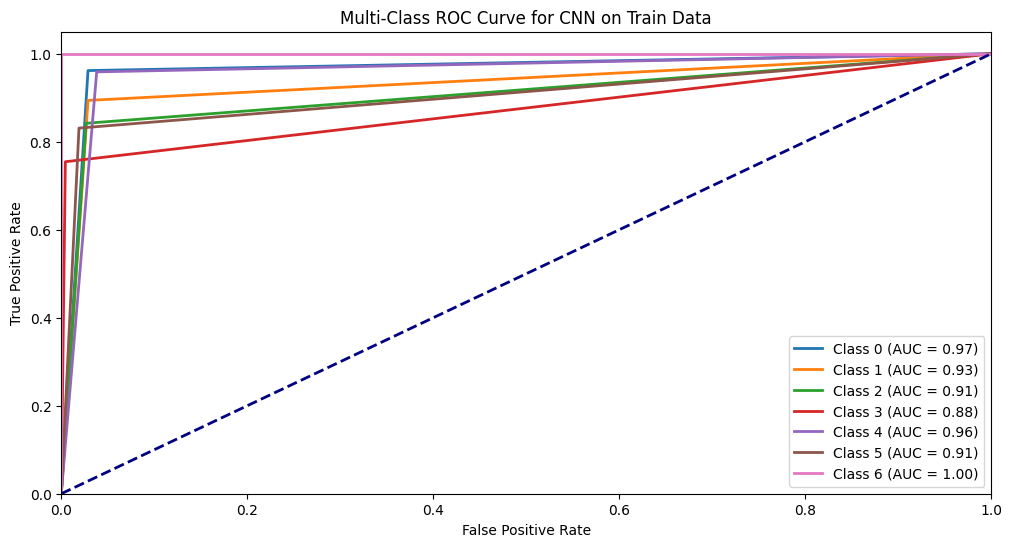

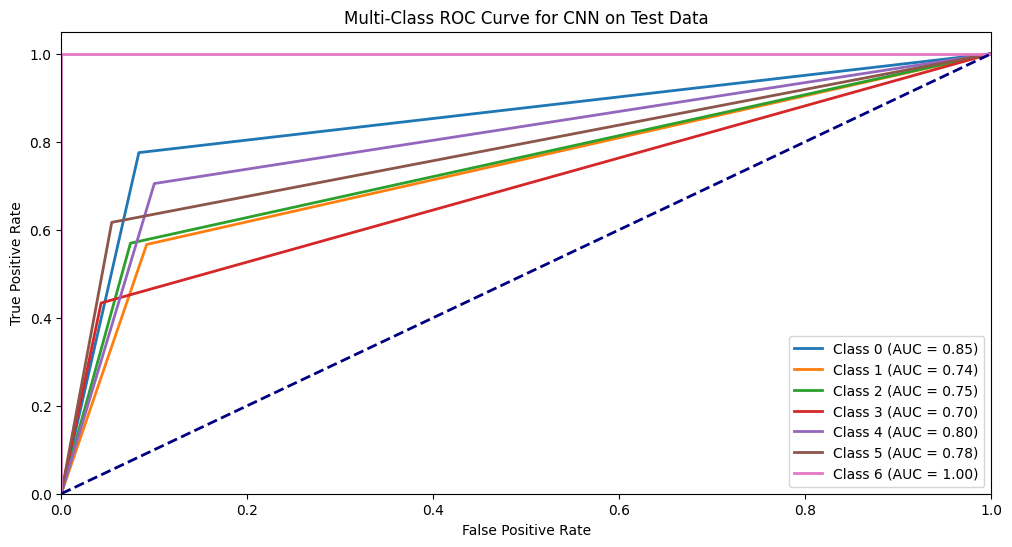

Saved model to disk
67/67 [==============================] - 0s 3ms/step
Overall Train Data ROC-AUC: 0.78
Overall Test Data ROC-AUC: 0.75
Overall Train Data ROC-AUC: 0.78
Overall Train Data ROC-AUC: 0.75


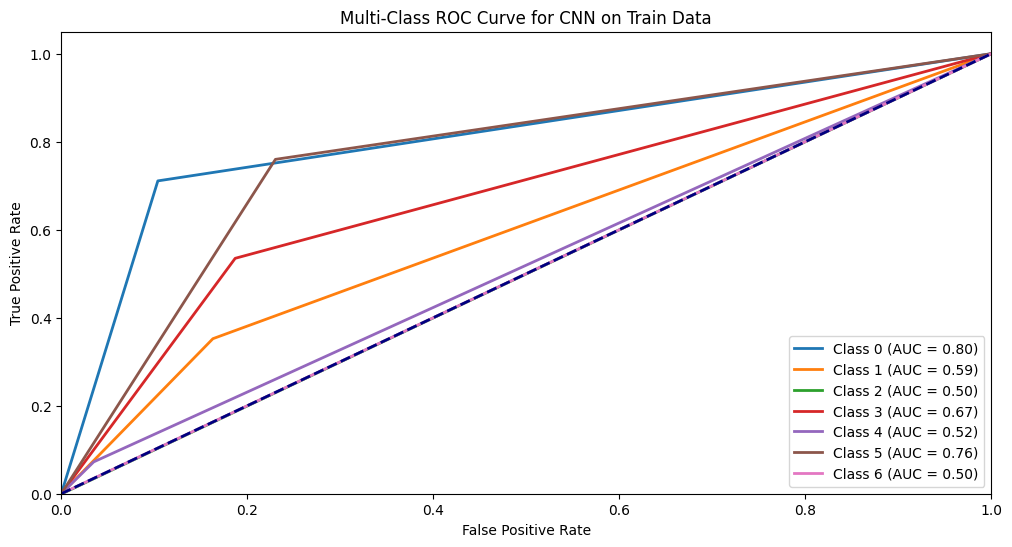

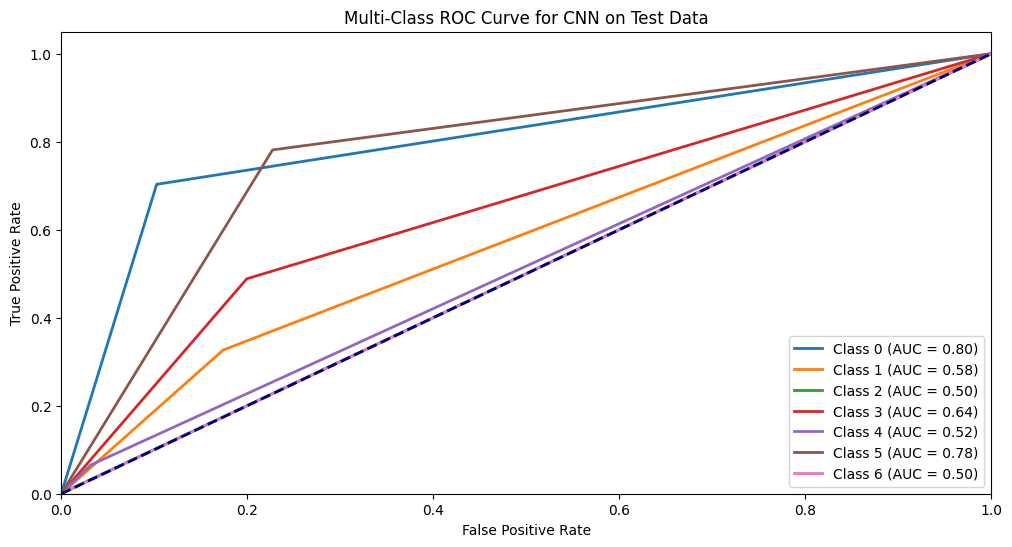

Saved model to disk


In [12]:
performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Train AUC ROC', 'Test AUC ROC'])
fol = 0
for fold in final_lst[0:2]:
  min_value = np.min(fold[0][0])
  max_value = np.max(fold[0][0])
  X_train = (fold[0][0] - min_value) / (max_value - min_value)
  X_test = (fold[0][1] - min_value) / (max_value - min_value)

  y_train = fold[1][0]
  y_test = fold[1][1]

  # Define the CNN model
  model = keras.Sequential([
      # Convolutional layer 1
      layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 1)),
      layers.MaxPooling2D((2, 2)),

      layers.Conv2D(16, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),


      # Flatten the feature maps
      layers.Flatten(),

      # Dense layers
      #layers.Dense(128, activation='relu'),

      layers.Dense(32, activation='relu'),
      # Output layer (for classification)
      layers.Dense(7, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc_roc')])

  # Print a summary of the model
  #model.summary()

  y_train_one_hot = to_categorical(y_train, num_classes=7)  # Assuming you have 7 classes
  y_test_one_hot = to_categorical(y_test, num_classes=7)

  model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), batch_size=32, epochs=10, verbose=False)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_auc = roc_auc_score(y_train, y_train_pred, average='weighted', multi_class='ovr')
  print(f"Overall Train Data ROC-AUC: {train_auc:.2f}")
  test_auc = roc_auc_score(y_test, y_test_pred, average='weighted', multi_class='ovr')
  print(f"Overall Test Data ROC-AUC: {test_auc:.2f}")


  generate_performance_values_plots([y_train, y_train_pred], [y_test, y_test_pred], label_mapping, performance_metric_values, 'CNN', fol)


  model_json = model.to_json()
  with open(f"Models/CNN_fold_{fol}.json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(f"Models/CNN_fold_{fol}.h5")
  print("Saved model to disk")
  fol += 1
  del model

gc.collect()
keras.backend.clear_session()

67/67 [==============================] - 0s 3ms/step
Overall Train Data ROC-AUC: 0.99
Overall Test Data ROC-AUC: 0.90
Overall Train Data ROC-AUC: 0.99
Overall Train Data ROC-AUC: 0.90


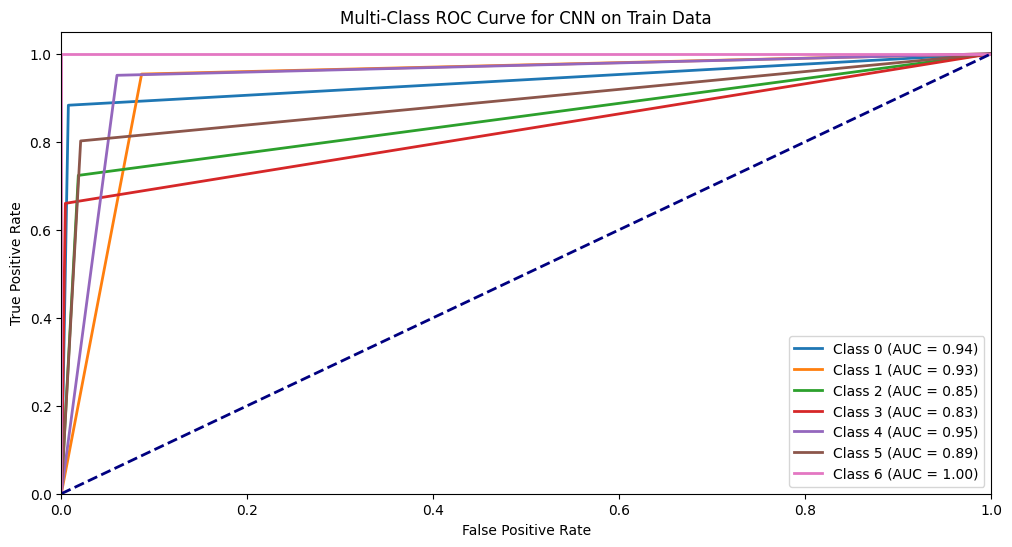

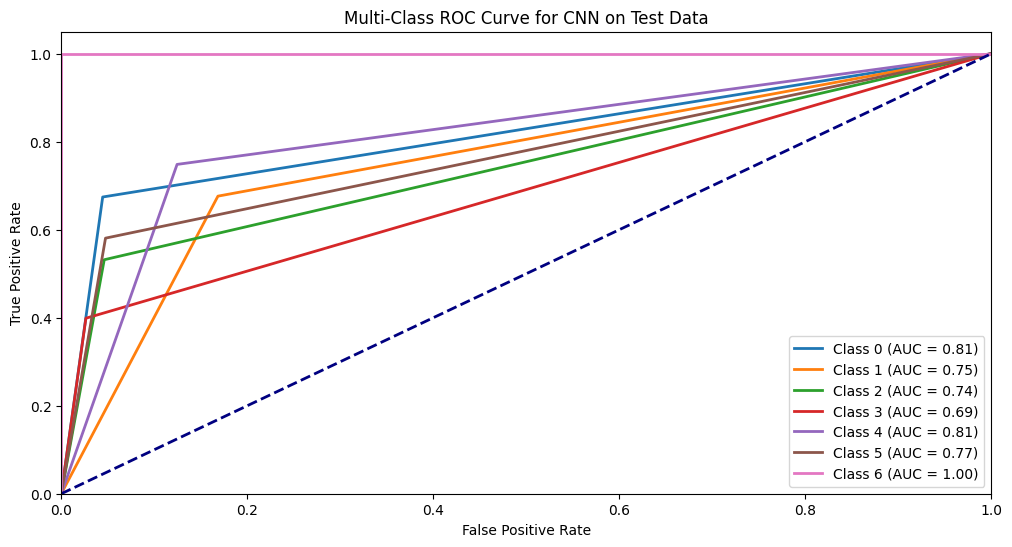

Saved model to disk


In [13]:
fol = 2
for fold in final_lst[2:3]:
  min_value = np.min(fold[0][0])
  max_value = np.max(fold[0][0])
  X_train = (fold[0][0] - min_value) / (max_value - min_value)
  X_test = (fold[0][1] - min_value) / (max_value - min_value)

  y_train = fold[1][0]
  y_test = fold[1][1]

  # Define the CNN model
  model = keras.Sequential([
      # Convolutional layer 1
      layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 1)),
      layers.MaxPooling2D((2, 2)),

      layers.Conv2D(16, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),


      # Flatten the feature maps
      layers.Flatten(),

      # Dense layers
      #layers.Dense(128, activation='relu'),

      layers.Dense(32, activation='relu'),
      # Output layer (for classification)
      layers.Dense(7, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc_roc')])

  # Print a summary of the model
  #model.summary()

  y_train_one_hot = to_categorical(y_train, num_classes=7)  # Assuming you have 7 classes
  y_test_one_hot = to_categorical(y_test, num_classes=7)

  model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), batch_size=32, epochs=10, verbose = False)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_auc = roc_auc_score(y_train, y_train_pred, average='weighted', multi_class='ovr')
  print(f"Overall Train Data ROC-AUC: {train_auc:.2f}")
  test_auc = roc_auc_score(y_test, y_test_pred, average='weighted', multi_class='ovr')
  print(f"Overall Test Data ROC-AUC: {test_auc:.2f}")


  generate_performance_values_plots([y_train, y_train_pred], [y_test, y_test_pred], label_mapping, performance_metric_values, 'CNN', fol)


  model_json = model.to_json()
  with open(f"Models/CNN_fold_{fol}.json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(f"Models/CNN_fold_{fol}.h5")
  print("Saved model to disk")
  fol += 1
  del model

gc.collect()
keras.backend.clear_session()

67/67 [==============================] - 0s 3ms/step
Overall Train Data ROC-AUC: 0.99
Overall Test Data ROC-AUC: 0.91
Overall Train Data ROC-AUC: 0.99
Overall Train Data ROC-AUC: 0.91


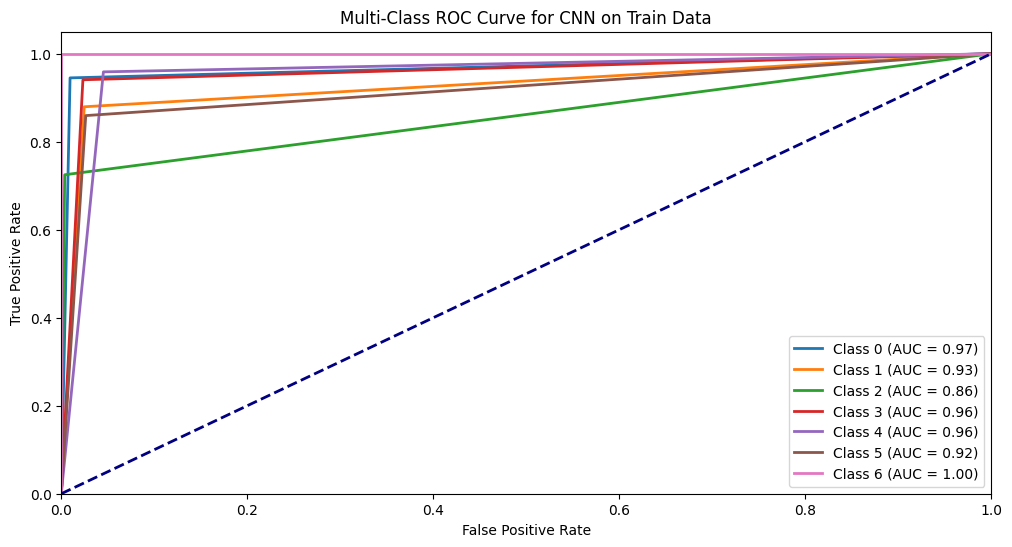

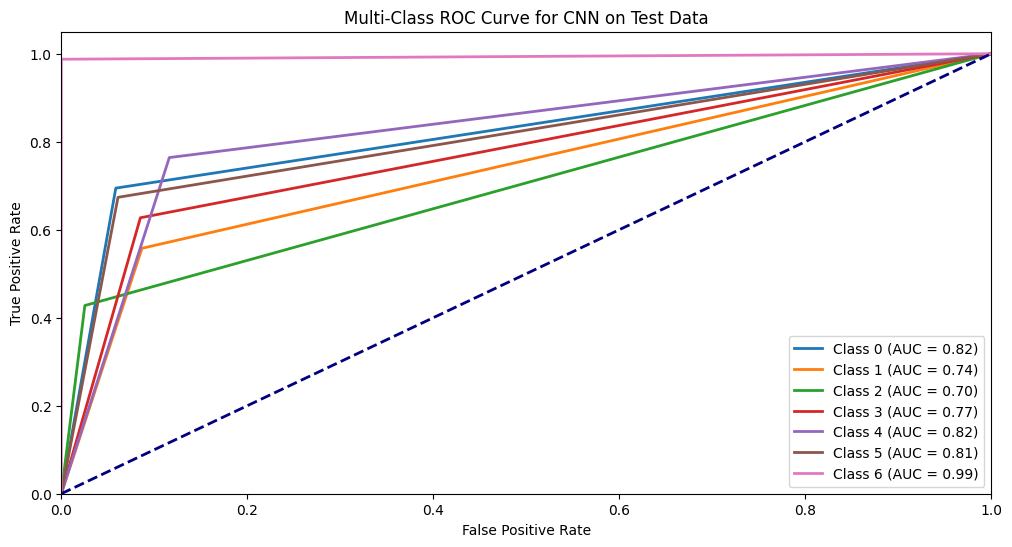

Saved model to disk
67/67 [==============================] - 0s 3ms/step
Overall Train Data ROC-AUC: 0.99
Overall Test Data ROC-AUC: 0.91
Overall Train Data ROC-AUC: 0.99
Overall Train Data ROC-AUC: 0.91


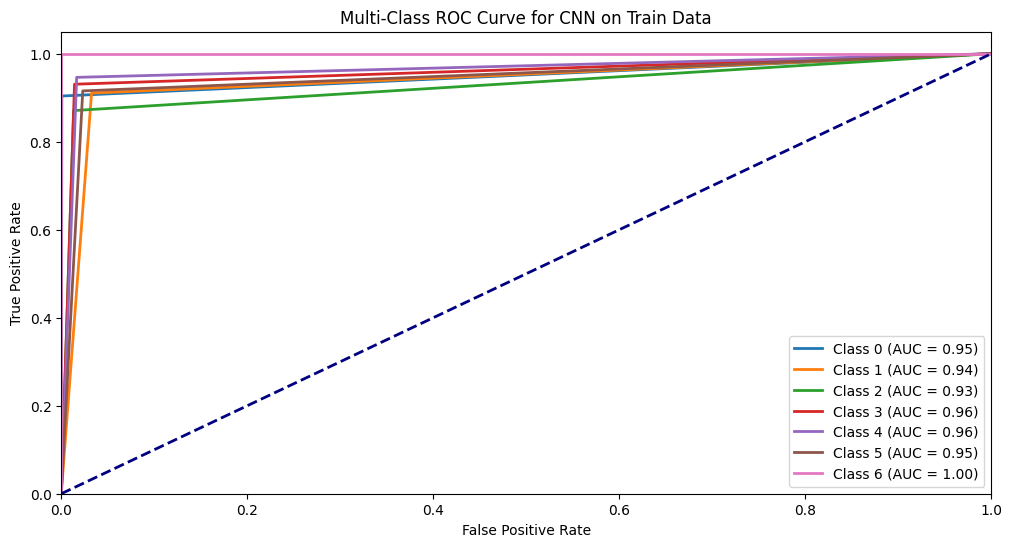

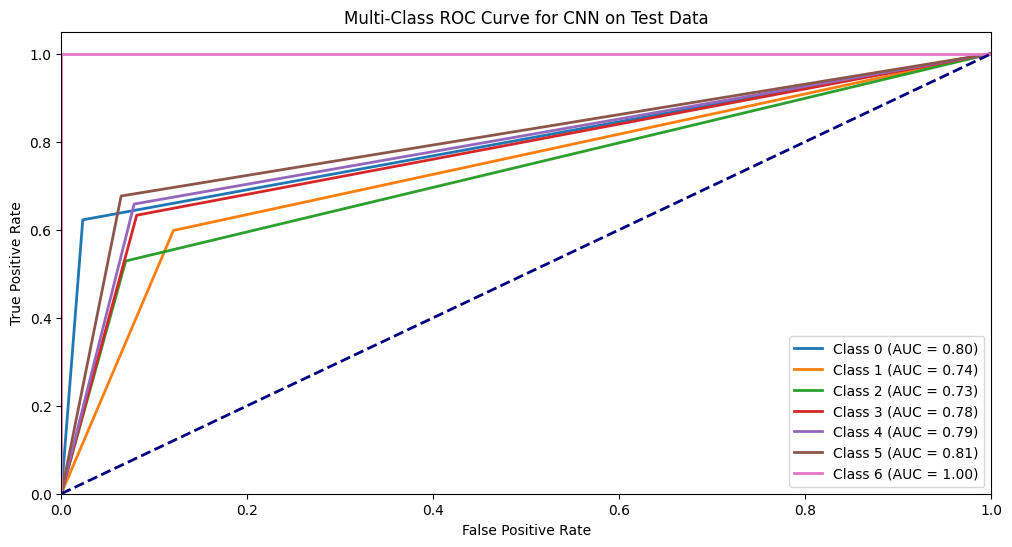

Saved model to disk


In [14]:
fol = 3
for fold in final_lst[3:]:
  min_value = np.min(fold[0][0])
  max_value = np.max(fold[0][0])
  X_train = (fold[0][0] - min_value) / (max_value - min_value)
  X_test = (fold[0][1] - min_value) / (max_value - min_value)

  y_train = fold[1][0]
  y_test = fold[1][1]

  # Define the CNN model
  model = keras.Sequential([
      # Convolutional layer 1
      layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 1)),
      layers.MaxPooling2D((2, 2)),

      layers.Conv2D(16, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),


      # Flatten the feature maps
      layers.Flatten(),

      # Dense layers
      #layers.Dense(128, activation='relu'),

      layers.Dense(32, activation='relu'),
      # Output layer (for classification)
      layers.Dense(7, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc_roc')])

  # Print a summary of the model
  #model.summary()

  y_train_one_hot = to_categorical(y_train, num_classes=7)  # Assuming you have 7 classes
  y_test_one_hot = to_categorical(y_test, num_classes=7)

  model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), batch_size=32, epochs=10, verbose = False)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_auc = roc_auc_score(y_train, y_train_pred, average='weighted', multi_class='ovr')
  print(f"Overall Train Data ROC-AUC: {train_auc:.2f}")
  test_auc = roc_auc_score(y_test, y_test_pred, average='weighted', multi_class='ovr')
  print(f"Overall Test Data ROC-AUC: {test_auc:.2f}")


  generate_performance_values_plots([y_train, y_train_pred], [y_test, y_test_pred], label_mapping, performance_metric_values, 'CNN', fol)


  model_json = model.to_json()
  with open(f"Models/CNN_fold_{fol}.json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(f"Models/CNN_fold_{fol}.h5")
  print("Saved model to disk")
  fol += 1
  del model

gc.collect()
keras.backend.clear_session()